# this is where I got it from

https://bpostance.github.io/posts/clustering-mixed-data/

In [35]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import preprocessing
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale,RobustScaler,StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
import sklearn.metrics as metrics
import sklearn.metrics as metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [18]:
raw = pd.read_csv('cleaned2.csv')
raw.head()

,title,runtime,imdb_score,imdb_votes,user_review_count,critic_review_count,critic_overall_score,critic_positive_score,critic_mixed_score,critic_negative_score,user_overall_score,user_positive_score,user_mixed_score,user_negative_score,#_of_nominations,#_of_wins
0,10,122.0,6.1,17623.0,82.0,51.0,68.0,4.0,1.0,2.0,5.8,3.0,2.0,1.0,2.0,0.0
1,12,159.0,7.6,14601.0,42.0,71.0,72.0,12.0,5.0,0.0,7.4,17.0,1.0,3.0,1.0,0.0
2,1941,118.0,5.8,33318.0,273.0,74.0,34.0,1.0,3.0,3.0,6.0,8.0,7.0,3.0,3.0,0.0
3,12 Angry Men,96.0,9.0,759612.0,1900.0,150.0,96.0,10.0,0.0,0.0,9.0,484.0,9.0,22.0,3.0,0.0
4,12 Monkeys,129.0,8.0,606901.0,722.0,197.0,74.0,16.0,4.0,0.0,8.7,453.0,30.0,12.0,2.0,0.0


In [19]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
titles = list(raw['title'])
le.fit(titles)
encoded_titles = le.transform(titles)
raw['title'] = encoded_titles

# example of a normalization
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
columns = ['title','runtime', 'imdb_score', 'imdb_votes', 'user_review_count', 'critic_review_count','critic_overall_score','critic_positive_score','critic_mixed_score','critic_negative_score','user_overall_score','user_positive_score','user_mixed_score','user_negative_score','#_of_nominations','#_of_wins']

# convert numerical-object to numericals
for col in columns:
    raw[col] = raw[col].replace('[^.0-9]', '', regex=True,).astype(float).fillna(0.0)

    # clean textual classes
for col in raw.select_dtypes(include='object').columns:
        raw[col] = raw[col].str.upper().replace('Z_','',regex=True).replace('[^A-Z]','',regex=True)
        
data_types = {f:t for f,t in zip(raw.columns,raw.dtypes)}

# copy df
df = raw.copy()
df = df.drop(labels=['title'],axis=1)
df = df.drop(labels=['#_of_wins'],axis=1)

data_meta = pd.DataFrame(df.nunique(),columns=['num'],index=None).sort_values('num').reset_index()
data_meta.columns = ['name','num']
data_meta['type'] = 'numerical'
#print(data_meta)


#data_meta.loc[(data_meta['num']<=15) & (~data_meta['name'].isin(['category','name','winner'])),'type']='categorical'
data_meta.loc[data_meta['name'].isin(['category','name']),'type']='categorical'

categorical_features = list(data_meta.loc[data_meta['type']=='categorical','name'])
numerical_features = list(data_meta.loc[data_meta['type']=='numerical','name'])
#print(numerical_features)


# Standard Scaled "mean normalisation"
scaler = StandardScaler()
scaler.fit(df[numerical_features])
#print("Feature Means:\t",[f"{x:.2}" for x in scaler.mean_])
numerical_data = scaler.transform(df[numerical_features])
numerical_data = pd.DataFrame(numerical_data,index=df.index,columns=numerical_features)
numerical_data[:2]



scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df[numerical_features])
numerical_data = scaler.transform(df[numerical_features])
numerical_data = pd.DataFrame(numerical_data,index=df.index,columns=numerical_features)
numerical_data[:2]


nominal_features = [c for c in categorical_features]
print("Nominals:\n",nominal_features)

nominal_data = list()
for i,x in df[nominal_features].nunique().iteritems():
    if x <= 2:
        nominal_data.append(pd.get_dummies(df[[i]],drop_first=True))
    elif x > 2:
        nominal_data.append(pd.get_dummies(df[[i]],drop_first=False))
        
#nominal_data = pd.concat(nominal_data,axis=1)

# transformed and scaled dataset
Xy_scaled = pd.concat([numerical_data],axis=1)
#print(f'Data min:max {Xy_scaled.min().min(),Xy_scaled.max().max()}')

# original data
Xy_original = df[numerical_features].copy()

Nominals:
 []


In [20]:
#reducing dimension using PCA.
#calculates the % of the data we still have of our original
pca_2 = PCA(n_components=2)
pca_2result=pca_2.fit_transform(Xy_scaled)
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))

Explained variation per principal component: [0.48319565 0.17405954]
Cumulative variance explained by 2 principal components: 65.73%


In [21]:
# candidate values for our cluster
candidate_values = [2,3,4,5,6]

# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': candidate_values})

Parameter: {'n_clusters': 2} Score 0.6554832376930296
Parameter: {'n_clusters': 3} Score 0.5064432087380419
Parameter: {'n_clusters': 4} Score 0.45300234326462047
Parameter: {'n_clusters': 5} Score 0.4356509400757678
Parameter: {'n_clusters': 6} Score 0.40595113511079806


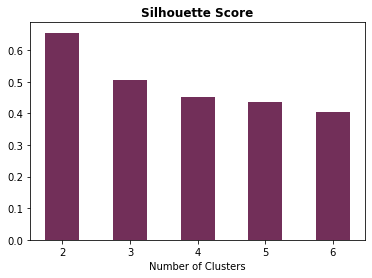

In [22]:
#picking the best K_means model
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []

# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(pca_2result)         # fit model on wine dataset, this will find clusters based on parameter p
    ss = metrics.silhouette_score(pca_2result, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(candidate_values))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

In [23]:
#We will now apply K-Means
# fitting KMeans    
optimum_num_clusters = 2
kmeans = KMeans(n_clusters= optimum_num_clusters,init="random")
kmeans.fit(pca_2result)
#kmeans.fit(Xy_scaled)

KMeans(init='random', n_clusters=2)

In [24]:
Xy_=pca_2result
#Xy_=Xy_scaled
clusters_ = kmeans.labels_

In [25]:
pred = pd.read_csv('test_data.csv')

titles_pred = list(pred['title'])
le.fit(titles_pred)
titles_pred = le.transform(titles_pred)
pred['title'] = titles_pred


columns_pred = ['title','runtime', 'imdb_score', 'imdb_votes', 'user_review_count', 'critic_review_count','critic_overall_score','critic_positive_score','critic_mixed_score','critic_negative_score','user_overall_score','user_positive_score','user_mixed_score','user_negative_score','#_of_nominations','#_of_wins']


    
for col in columns_pred:
    pred[col] = pred[col].replace('[^.0-9]', '', regex=True,).astype(float).fillna(0.0)

    

for col in pred.select_dtypes(include='object').columns:
        pred[col] = pred[col].str.upper().replace('Z_','',regex=True).replace('[^A-Z]','',regex=True)

dp = pred.copy()
dp = dp.drop(labels=['title'],axis=1)
dp = dp.drop(labels=['#_of_wins'],axis=1)

#print(data_count)
data_count_dp = pd.DataFrame(dp.nunique(),columns=['num'],index=None).sort_values('num').reset_index()
data_count_dp.columns = ['name','num']
data_count_dp['type'] = 'numerical'

#data_count_dp.loc[data_count_dp['name'].isin(['category']),'type']='nominal'

nominal_features_dp = list(data_count_dp.loc[data_count_dp['type']=='nominal','name'])
numerical_features_dp = list(data_count_dp.loc[data_count_dp['type']=='numerical','name'])

scaler_dp = StandardScaler()
scaler_dp.fit(dp[numerical_features_dp])
print("Feature Means:\t",[f"{x:.2}" for x in scaler_dp.mean_])
numerical_data_dp = scaler_dp.transform(dp[numerical_features_dp])
numerical_data_dp = pd.DataFrame(numerical_data_dp,index=dp.index,columns=numerical_features_dp)
numerical_data_dp[:2]

scaler_dp = MinMaxScaler(feature_range=(0,1))
scaler_dp.fit(dp[numerical_features_dp])
numerical_data_dp = scaler_dp.transform(dp[numerical_features_dp])
numerical_data_dp = pd.DataFrame(numerical_data_dp,index=dp.index,columns=numerical_features_dp)


# transformed and scaled dataset
Xy_scaled_dp = pd.concat([numerical_data_dp],axis=1)
print(f'Data min:max {Xy_scaled.min().min(),Xy_scaled.max().max()}')

print(Xy_scaled_dp.shape)
# original data
Xy_original_dp = dp[numerical_features_dp].copy()

column_names_dp = Xy_scaled_dp.columns.values
column_names_dp.shape

Feature Means:	 ['1.7', '4.8', '8.0', '4.9', '8.1', '5e+01', '4.1e+01', '7.8e+01', '1.3e+02', '4.2e+05', '1.3e+03', '1.2e+03', '9.1e+01', '8.1e+01']
Data min:max (0.0, 1.0)
(12, 14)


(14,)

In [26]:
#reducing dimension using PCA.
#calculates the % of the data we still have of our original
pca_3 = PCA(n_components=2)
pca_3result=pca_2.fit_transform(Xy_scaled_dp)
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))

Explained variation per principal component: [0.48296128 0.26214879]
Cumulative variance explained by 2 principal components: 74.51%


In [27]:
kmeans.predict(pca_3result)
#kmeans.predict(Xy_original_dp)

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1])

In [28]:
from sklearn.cluster import KMeans
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

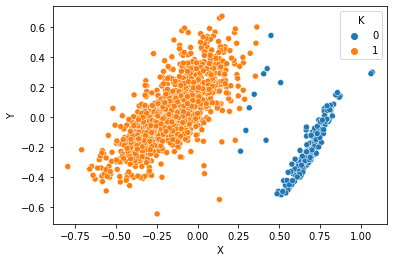

In [30]:
#Xy_,clusters_ = make_blobs(n_samples=4000, centers=5, cluster_std=0.7)
df_ = pd.DataFrame(Xy_,columns=['X','Y'])
df_['K'] = clusters_
sns.scatterplot(x='X',y='Y',hue='K',data=df_);

In [52]:
train = raw.copy()
train = train['#_of_wins']

train2 = pd.read_csv('test_data.csv')
train2 = train2['#_of_wins']

X_train = pca_2result
y_train = np.array(train)

X_test = pca_3result
y_test = np.array(train2)

In [56]:
y_train2=[]
for i in range(len(y_train)):
    if y_train[i]==0:
        y_train2.append(0)
    else:
        y_train2.append(1)
        
        
y_test2=[]
for i in range(len(y_test)):
    if y_test[i]==0:
        y_test2.append(0)
    else:
        y_test2.append(1)
y_test2

[1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0]

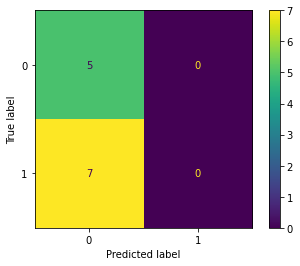

In [59]:
clf = SVC(random_state=0)
clf.fit(X_train, y_train2)

SVC(random_state=0)
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test2, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

plt.show()

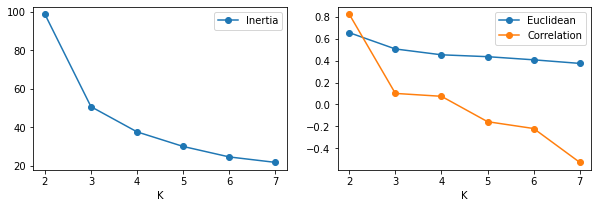

In [15]:
results = dict()
k_cand = [2,3,4,5,6,7] #

for k in k_cand:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Xy_)
    score0 = kmeans.inertia_
    score1 = silhouette_score(Xy_,kmeans.labels_,metric='euclidean')
    score2 = silhouette_score(Xy_,kmeans.labels_,metric='correlation')
    results[k] = {'k':kmeans,'s0':score0,'s1':score1,'s2':score2}

fig,axs = plt.subplots(1,2,sharex=True,figsize=(10,3))
axs[0].plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Inertia')
axs[1].plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Euclidean')
axs[1].plot([i for i in results.keys()],[i['s2'] for i in results.values()],'o-',label='Correlation')
for ax in axs:
    ax.set_xticks(k_cand)
    ax.set_xlabel('K')
    ax.legend()

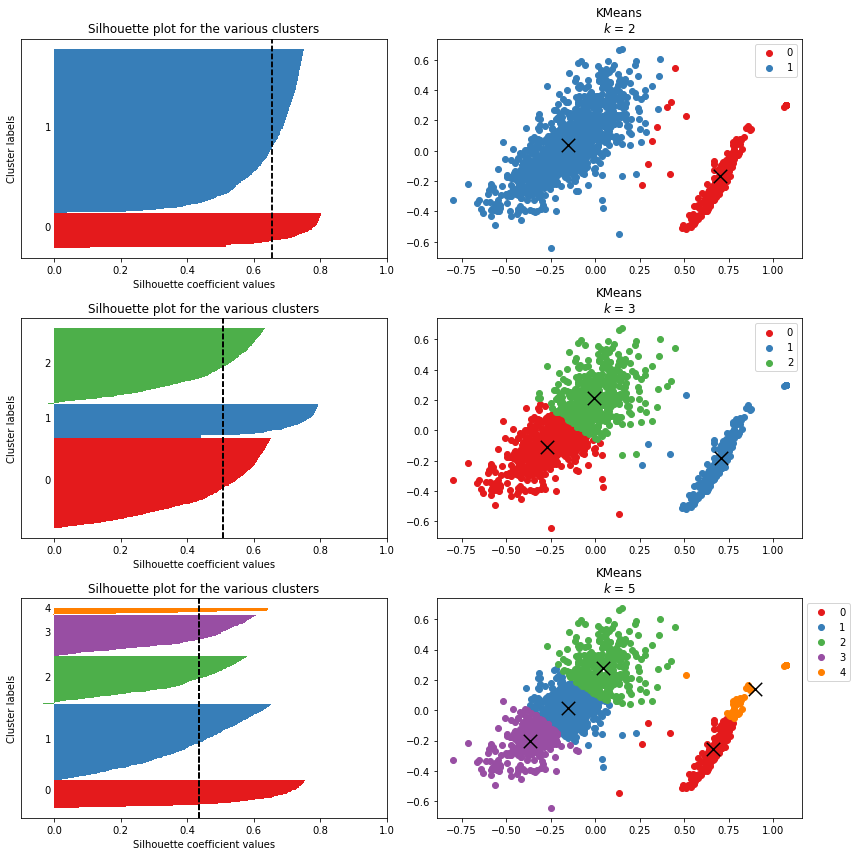

In [16]:
k_cand = [2,3,5]

fig,axs = plt.subplots(len(k_cand),2,figsize=(12,12))

for e,k in enumerate(k_cand):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Xy_)
    
    cdict = {i:cm.Set1(i) for i in np.unique(kmeans.labels_)}
    
    ## silhouette samples
    silhouette_vals = silhouette_samples(Xy_,kmeans.labels_)
    y_lower = 0 
    y_upper = 0
    for i,cluster in enumerate(np.unique(kmeans.labels_)):
        cluster_silhouette_vals = silhouette_vals[kmeans.labels_==cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        axs[e,0].barh(range(y_lower,y_upper),
                      cluster_silhouette_vals,
                      height=1,
                      color=cdict[cluster])
        axs[e,0].text(-0.03,(y_lower+y_upper)/2,str(i))
        
        y_lower += len(cluster_silhouette_vals) # add for next iteration 
        avg_score = np.mean(silhouette_vals)
        axs[e,0].axvline(avg_score,linestyle ='--',color = 'black')
        
        axs[e,0].set_yticks([])
        axs[e,0].set_xlim([-0.1, 1])
        axs[e,0].set_xlabel('Silhouette coefficient values')
        axs[e,0].set_ylabel('Cluster labels')
        axs[e,0].set_title('Silhouette plot for the various clusters')
        
    ## plot data and cluster centroids
    results = pd.DataFrame(Xy_)
    results['k'] = kmeans.labels_
    for cluster in np.unique(kmeans.labels_): # plot data by cluster
        axs[e,1].scatter(x=results.where(results['k']==cluster)[0],
                         y=results.where(results['k']==cluster)[1],
                         color=cdict[cluster],
                         label=cluster)
    # plot centroids
    axs[e,1].scatter(x=kmeans.cluster_centers_[:,0],
                     y=kmeans.cluster_centers_[:,1],
                     marker='x',color='black',s=180)
    axs[e,1].legend(bbox_to_anchor=(1,1))
    axs[e,1].set_title(f"KMeans\n$k$ = {k}")
    plt.tight_layout()

In [ ]:
#a,b = make_blobs(n_samples=4000,n_features=5, centers=5, cluster_std=0.7)
a = pca_2result
b = kmeans.labels_

kmeans = KMeans(n_clusters=5, random_state=0).fit(a)

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne = tsne_model.fit_transform(a)
tsne = pd.DataFrame(tsne)
tsne['k'] = kmeans.labels_

for cluster in np.unique(kmeans.labels_): # plot data by cluster
    plt.scatter(x=tsne.where(tsne['k']==cluster)[0],
                y=tsne.where(tsne['k']==cluster)[1],
                color=cdict[cluster],
                label=cluster)

plt.scatter(kmeans.cluster_centers_[:,0],
            kmeans.cluster_centers_[:,1],
            marker='x',color='black',s=180,
            label='centroids')
plt.legend();

In [ ]:
results = dict()
k_cand = list(np.arange(5,55,5))
k_cand.extend(list(np.arange(50,500,50)))
#print(k_cand)

for k in k_cand:
    #print(k)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Xy_scaled)
    score0 = kmeans.inertia_
    score1 = silhouette_score(Xy_,kmeans.labels_,metric='euclidean')
    score2 = silhouette_score(Xy_,kmeans.labels_,metric='correlation')
    results[k] = {'k':kmeans,'s0':score0,'s1':score1,'s2':score2}
    #print(k)

fig,axs = plt.subplots(2,1,sharex=True,figsize=(16,8))
axs[0].plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Inertia')
axs[1].plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Euclidean')
axs[1].plot([i for i in results.keys()],[i['s2'] for i in results.values()],'o-',label='Correlation')
for ax in axs:
    ax.set_xticks(k_cand)
    ax.set_xlabel('K')
    ax.legend()

In [ ]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne = tsne_model.fit_transform(pca_2result)
tsne = pd.DataFrame(tsne)
tsne['k'] = results[400]['k'].labels_

for cluster in np.unique(kmeans.labels_): # plot data by cluster
    plt.scatter(x=tsne.where(tsne['k']==cluster)[0],
                y=tsne.where(tsne['k']==cluster)[1]
               )

In [ ]:
from pyclustering.cluster.kmedoids import kmedoids
from scipy.spatial.distance import pdist,squareform

In [ ]:
from pyclustering.cluster.clarans import clarans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# synthetic clusters
#I,c = make_blobs(10302,n_features=36,centers=5)

I = pca_2result
c = kmeans.labels_


# implement clarans
clarans_instance = clarans(I.tolist(), 5, 2, 4);
%time clarans_instance.process()
clusters = clarans_instance.get_clusters()
medoids = clarans_instance.get_medoids()

fig,axs=plt.subplots(1,2,figsize=(10,5))
axs[0].scatter(I[:,1],I[:,0],c=c)
axs[0].set_title('Synthetic clusters')
axs[1].set_title('CLARANS clusters')
for c_,m in zip(clusters,medoids):
    axs[1].scatter(I[c_,1],I[c_,0])
    axs[1].scatter(I[m,1],I[m,0],marker='x',c='black',label='medoids')

In [ ]:
import sys
!{sys.executable} -m pip install gower
import gower

In [ ]:
cat = [True if x in categorical_features else False for x in Xy_original.columns]

n = 5
focus = Xy_original.sample(1)
similar = gower.gower_topn(focus,Xy_original,
                           n=n,cat_features=cat)

In [ ]:
print(similar['values'])
Xy_original.iloc[similar['index']]

In [ ]:
# create list of cat_feature indicator
cat = [True if x in categorical_features else False for x in Xy_original.columns]

%time gd = gower.gower_matrix(Xy_original, cat_features=cat)

In [ ]:
print(f"Data shape: {Xy_original.shape}\nMatrix shape: {gd.shape}")
pd.DataFrame(gd[:3,:3])

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [ ]:
# condensed matrix
#gdv = squareform(gd,force='tovector')

# output matrix has format [idx1, idx2, dist, sample_count]
Z = linkage(Xy_,method='complete')
Z_df = pd.DataFrame(Z,columns=['id1','id2','dist','n'])
Z_df[:2]

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(25,5))
dn = dendrogram(Z, truncate_mode='level',p=5,show_leaf_counts=True,ax=axs);
print(f"Leaves = {len(dn['leaves'])}")

In [ ]:
# find k clusters
results = dict()
k_cand = list(np.arange(5,55,5))
k_cand.extend(list(np.arange(50,500,50)))

for k in k_cand:
    #print(k)
    cluster_array = fcluster(Z, k, criterion='maxclust')
    score0 = silhouette_score(gd, cluster_array, metric='precomputed')
    score1 = silhouette_score(Xy_scaled, cluster_array,metric='cityblock')
    results[k] = {'k':cluster_array,'s0':score0,'s1':score1}
    
fig,axs = plt.subplots(1,1,figsize=(16,5))
axs.plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Gower')
axs.plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Cityblock')
axs.set_xlim(1,451)
axs.set_xticks(k_cand)
axs.set_xlabel('K')
axs.legend();

In [ ]:
fig,axs = plt.subplots(3,1,figsize=(15,9),sharex=False)
Xy_original['k'] = results[5]['k']

Xy_original['k'].value_counts().sort_index().plot.bar(ax=axs[0])
Xy_original.boxplot(by='k',column='#_of_nominations',ax=axs[1])
Xy_original.boxplot(by='k',column='imdb_score',ax=axs[2])